In [1]:
import os
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import scipy.io

In [2]:
plt.gray()
None

<Figure size 640x480 with 0 Axes>

## 1 Levin et al

Motion Blur

In [3]:
def show_images(files: list, start_ind: int, end_ind: int):
    fig, axs = plt.subplots(3, 8, figsize=(20, 8))
    for i, file in enumerate(files[start_ind:end_ind]):
        img = scipy.io.loadmat(file)
        psf = img['f']
        x = img['x']
        y = img['y']
        axs[0, i].imshow(x)
        axs[0, i].axis('off')
        axs[1, i].imshow(y)
        axs[1, i].axis('off')
        axs[2, i].imshow(psf)
        axs[2, i].axis('off')

In [4]:
def save_image(filename: str):
    image =  scipy.io.loadmat(filename)
    new_filename = os.path.split(filename)[-1].split('.')[0]
    y = (image['y'] * 255).astype(np.uint8)

    plt.figure(figsize=(4, 4))
    plt.imshow(y)
    plt.axis('off')
    plt.title(new_filename)
    plt.show()

    im = Image.fromarray(y)
    im.save(f'/home/chaganovaob/edu/neural-deconvolution/datasets/levin/jpg/{new_filename}.jpg')

In [5]:
files = sorted(list(Path('/home/chaganovaob/edu/neural-deconvolution/datasets/levin/Levin09blurdata/').rglob('*.mat')))
len(files)

32

In [6]:
img = scipy.io.loadmat(files[0])
x = img['x']
y = img['y']
psf = img['f']
print(f'Shape of the kernel: {psf.shape}')
print(f'Shape of original image: {x.shape}')
print(f'Shape of the blurred image: {y.shape}')

Shape of the kernel: (19, 19)
Shape of original image: (255, 255)
Shape of the blurred image: (255, 255)


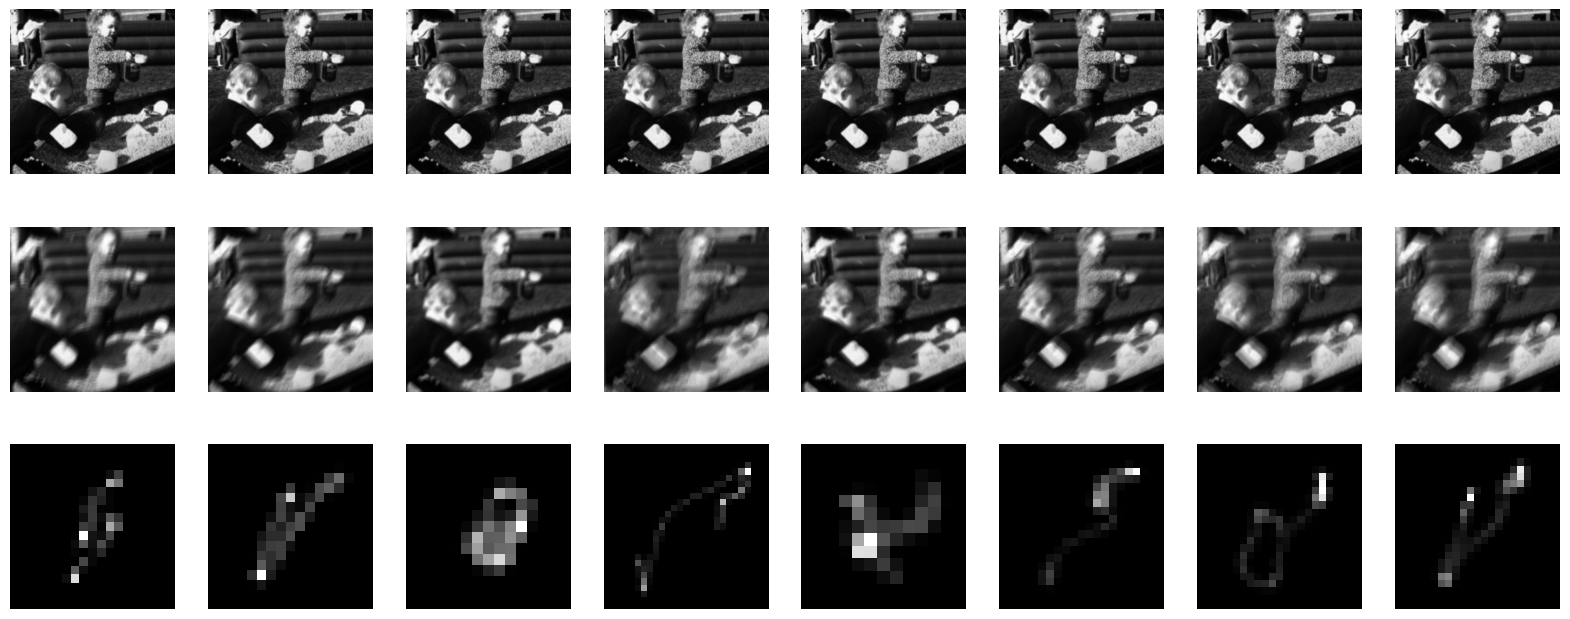

In [7]:
show_images(files, start_ind=0, end_ind=8)

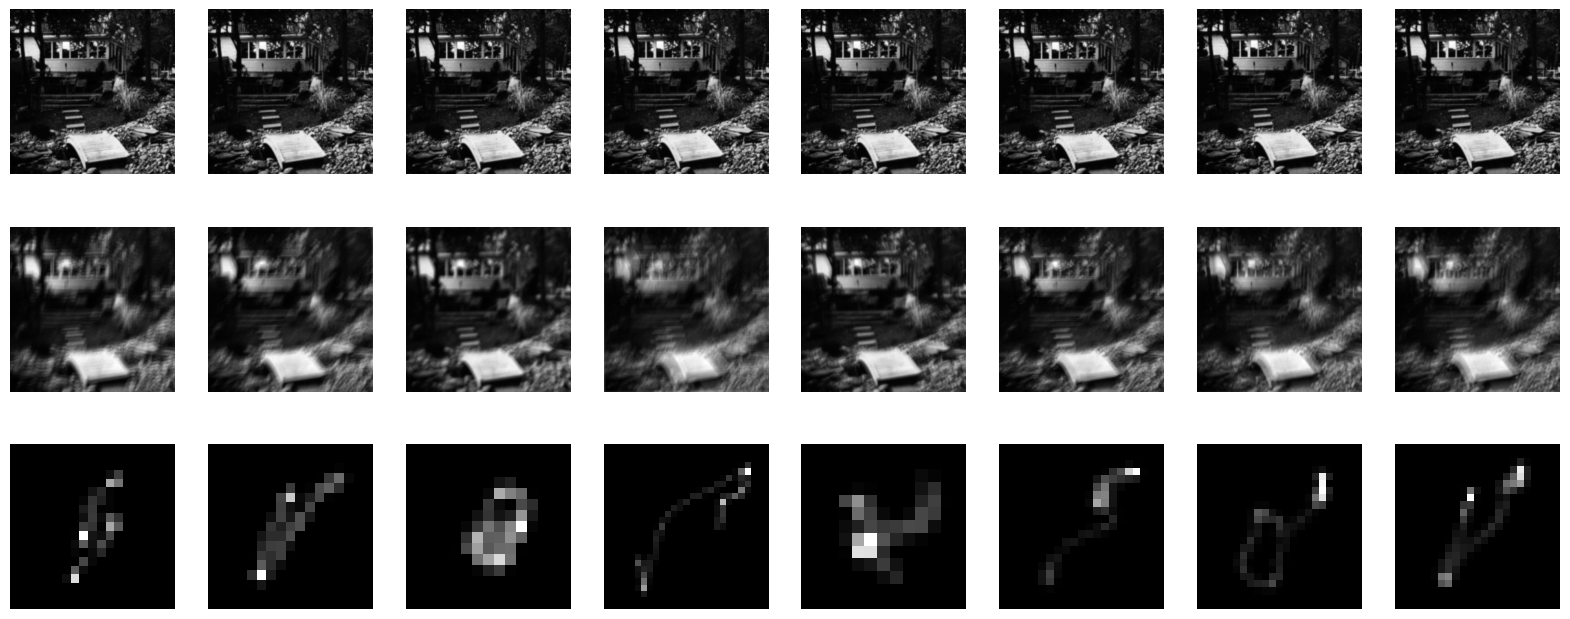

In [8]:
show_images(files, start_ind=8, end_ind=16)

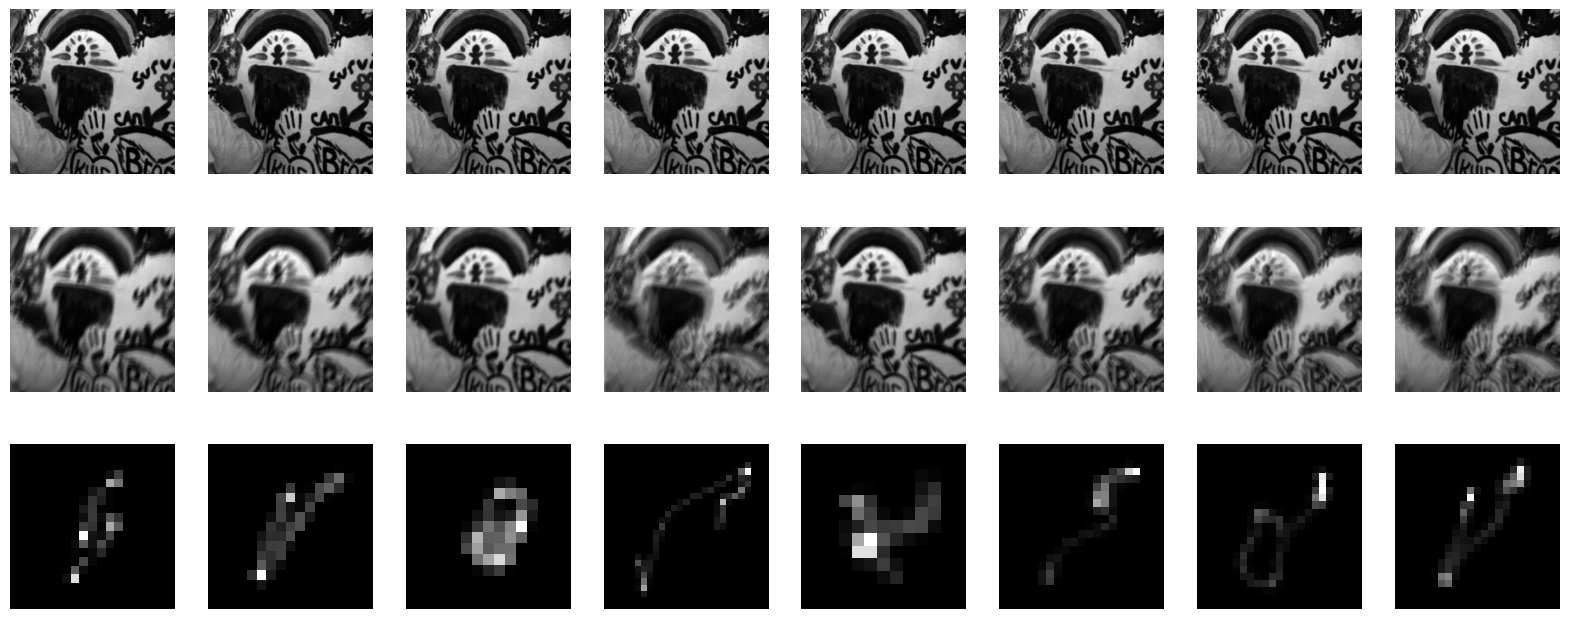

In [9]:
show_images(files, start_ind=16, end_ind=24)

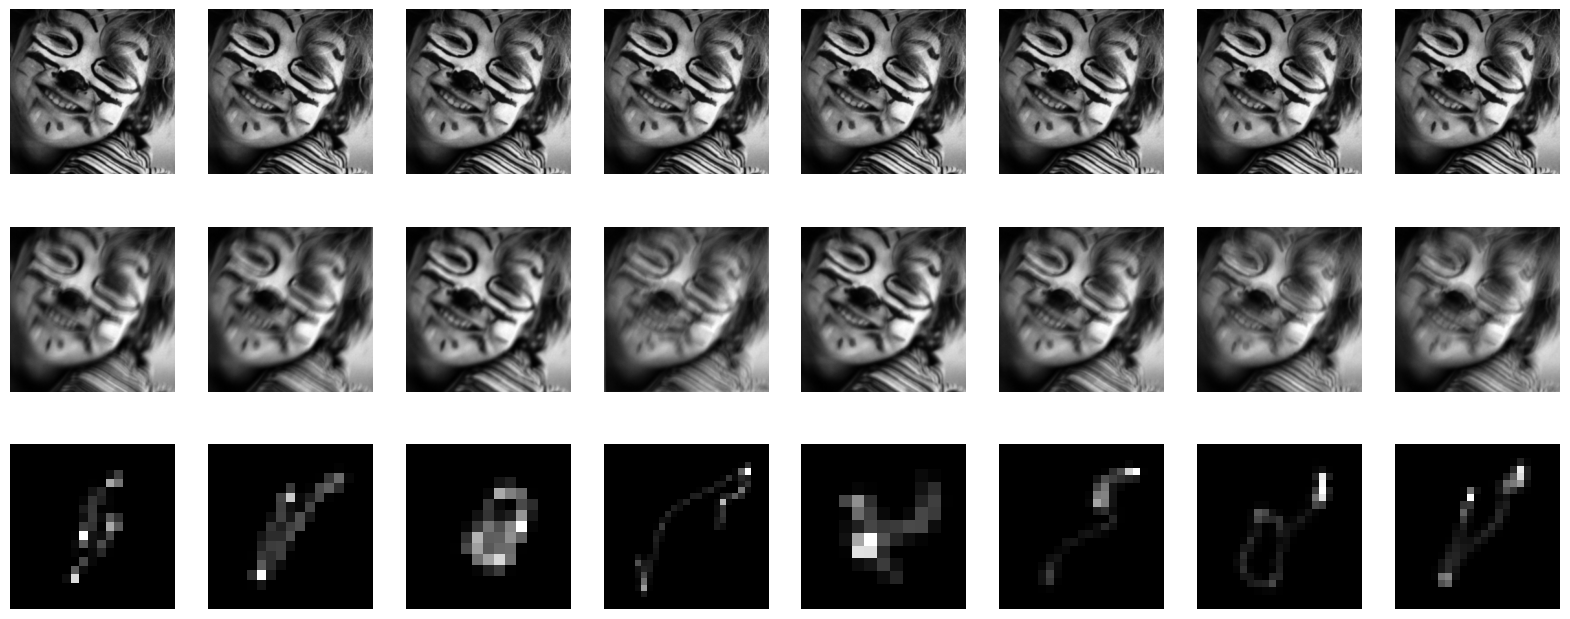

In [10]:
show_images(files, start_ind=24, end_ind=32)

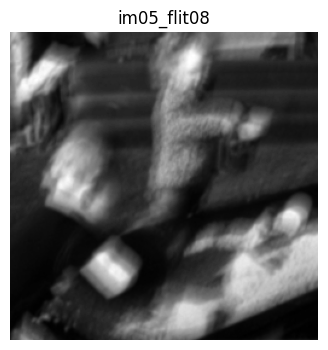

In [11]:
save_image(files[7])

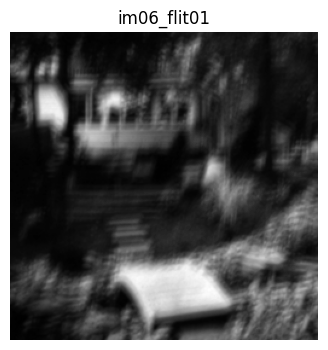

In [12]:
save_image(files[8])

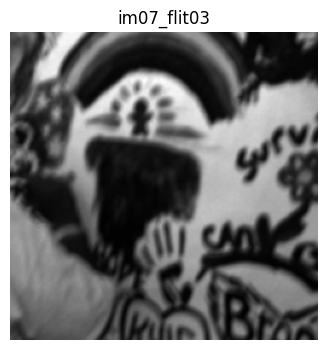

In [13]:
save_image(files[18])

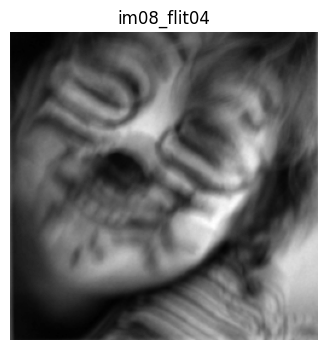

In [14]:
save_image(files[27])

# 2 Ours

Eyes PSF

In [15]:
import sys
sys.path.append('../')

import typing as tp
from pathlib import Path, PosixPath

import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.data.convolution import convolve
from src.data.utils import read_image
from src.deconv.classic.richardson_lucy import richardson_lucy_rgb
from src.deconv.classic.wiener import wiener_rgb
from src.metrics import psnr, ssim, mse, rmse

In [16]:
def show_images(files: tp.List[np.array]):
    fig, axs = plt.subplots(1, len(files), figsize=(4 * len(files), 4))
    for i, file in enumerate(files):
        img = read_image(str(file))
        axs[i].imshow(img)
        axs[i].axis('off')


## 2.1 Original data

### 2.1.1 Icons

In [17]:
icons = list(Path('/home/chaganovaob/edu/deconvolution-benchmark/data/icons_jpg').rglob('*.png'))
print(f'Total count: {len(icons)}')

Total count: 104


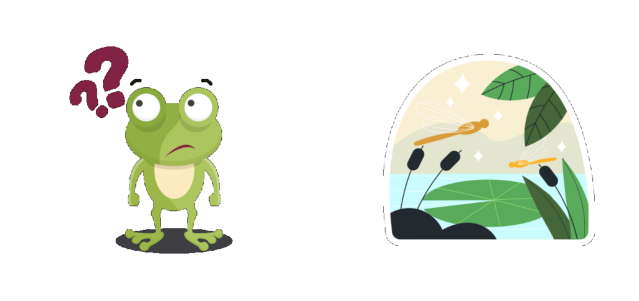

In [18]:
show_images(icons[:2])

 ### 2.1.2 Animals 

In [19]:
animals = list(Path('/home/chaganovaob/edu/deconvolution-benchmark/data/images/animals').rglob('*.jpg'))
print(f'Total count: {len(animals)}')

Total count: 100


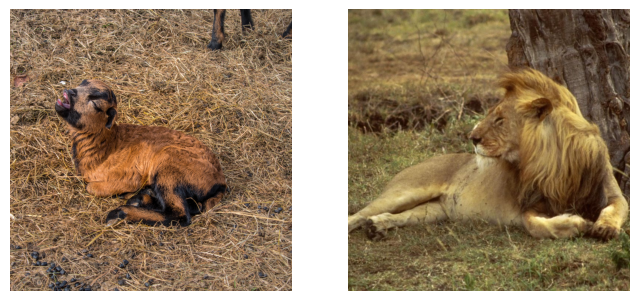

In [20]:
show_images(animals[:2])

### 2.1.3 City

In [21]:
cities = list(Path('/home/chaganovaob/edu/deconvolution-benchmark/data/images/city').rglob('*.jpg'))
print(f'Total count: {len(cities)}')

Total count: 101


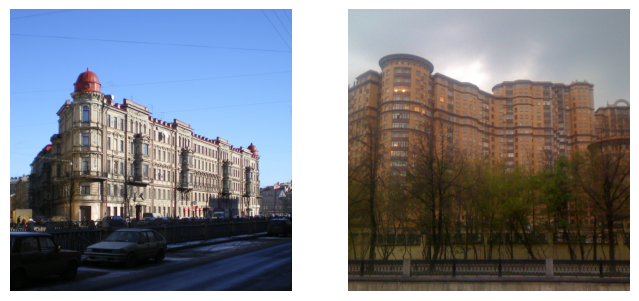

In [22]:
show_images(cities[:2])

### 2.1.4 Faces

In [23]:
faces = list(Path('/home/chaganovaob/edu/deconvolution-benchmark/data/images/faces').rglob('*.jpg'))
print(f'Total count: {len(faces)}')

Total count: 102


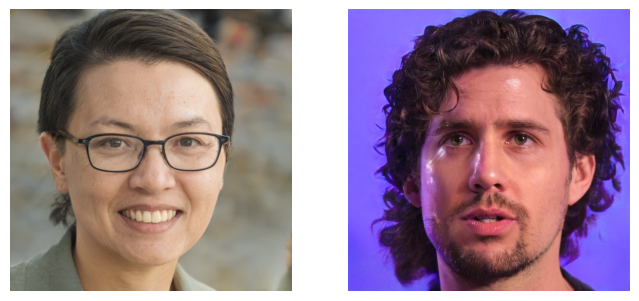

In [24]:
show_images(faces[:2])

### 2.1.5 Nature

In [25]:
natures = list(Path('/home/chaganovaob/edu/deconvolution-benchmark/data/images/nature').rglob('*.jpg'))
print(f'Total count: {len(natures)}')

Total count: 103


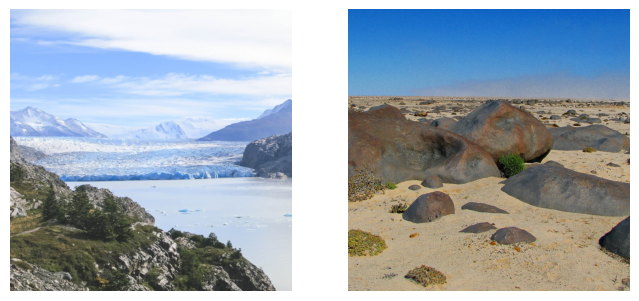

In [26]:
show_images(natures[:2])

### 2.1.6 Texts

In [27]:
texts = list(Path('/home/chaganovaob/edu/deconvolution-benchmark/data/texts').rglob('*.jpg'))
print(f'Total count: {len(texts)}')

Total count: 225


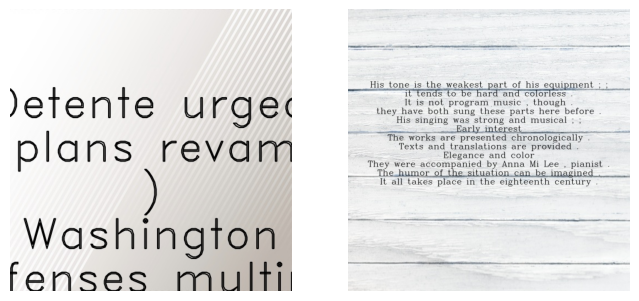

In [28]:
show_images(texts[:2])

### 2.1.7 PSF

In [29]:
def cat_psfs(psfs_list: PosixPath) -> np.array:
    psfs = np.load(psfs_list[0], allow_pickle=True)
    for psf_path in psfs_list[1:]:
        psf = np.load(psf_path, allow_pickle=True)
        psfs = np.hstack([psfs, psf])
    return psfs

In [30]:
def show_psf(psfs: np.array):
    fig, axs = plt.subplots(1, len(psfs), figsize=(4 * len(psfs), 4))
    plt.gray()
    for i, psf in enumerate(psfs):
        psf_image = psf['psf']
        S = psf['S']
        A = psf['A']
        C = psf['C']
        axs[i].imshow(psf_image)
        axs[i].axis('off')
        axs[i].set_title(f'S: {S} A: {A} C: {C}')

#### 2.1.7.1 Big

In [31]:
big_psfs_list = list(Path('/home/chaganovaob/edu/deconvolution-benchmark//data/psf/psf').rglob('big_psf*.npy'))
print(f'Total count: {len(big_psfs_list)}')

Total count: 7


(512, 512)

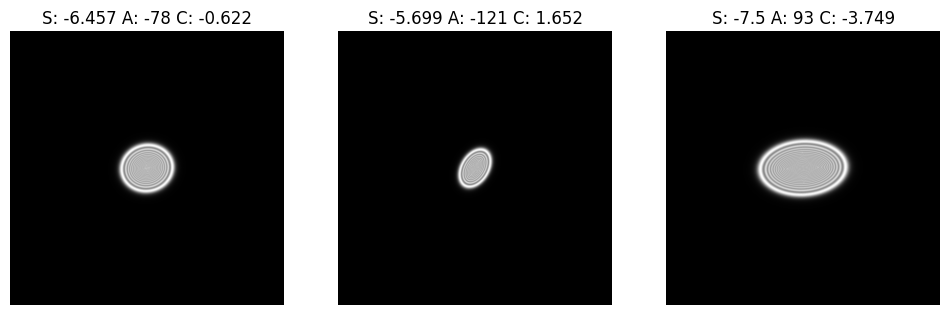

In [32]:
big_psfs = cat_psfs(big_psfs_list)
show_psf(big_psfs[0:3])

big_psfs[0]['psf'].shape

#### 2.1.7.2 Medium

In [33]:
medium_psfs_list = list(Path('/home/chaganovaob/edu/deconvolution-benchmark/data/psf/psf').rglob('medium_psf*.npy'))
print(f'Total count: {len(medium_psfs_list)}')

Total count: 7


(512, 512)

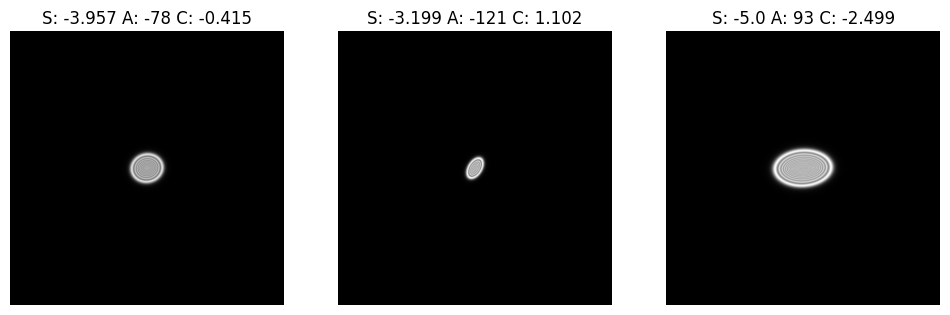

In [34]:
medium_psfs = cat_psfs(medium_psfs_list)
show_psf(medium_psfs[0:3])

medium_psfs[0]['psf'].shape

## 2.2 Blurred images

In [35]:
def show_blurred(img_paths: tp.List[PosixPath], psfs_list: tp.List[np.array]):
    num_images = len(img_paths)
    fig, axs = plt.subplots(3, num_images, figsize=(3*num_images, 8))
    for i in range(num_images):
        image = read_image(str(img_paths[i]))
        psf = np.load(str(psfs_list[0]), allow_pickle=True)[i]['psf']
        convolved = convolve(image, psf)

        axs[0, i].imshow(image)
        axs[0, i].axis('off')
        axs[0, i].set_title('Original')

        axs[1, i].imshow(convolved)
        axs[1, i].axis('off')
        axs[1, i].set_title('Blurred')

        axs[2, i].imshow(psf)
        axs[2, i].axis('off')
        axs[2, i].set_title('PSF')

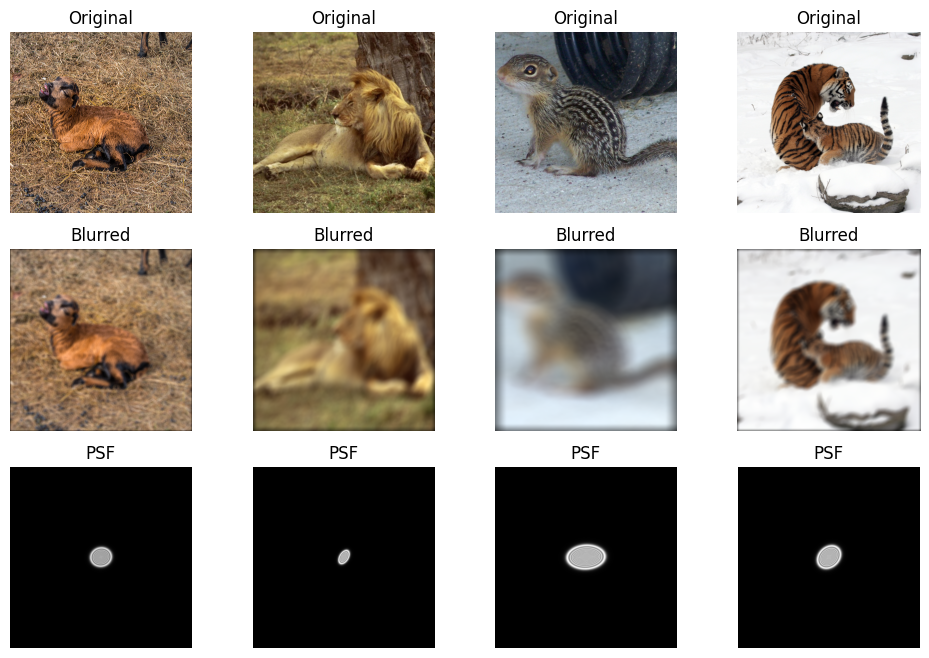

In [36]:
show_blurred(animals[:4], medium_psfs_list)

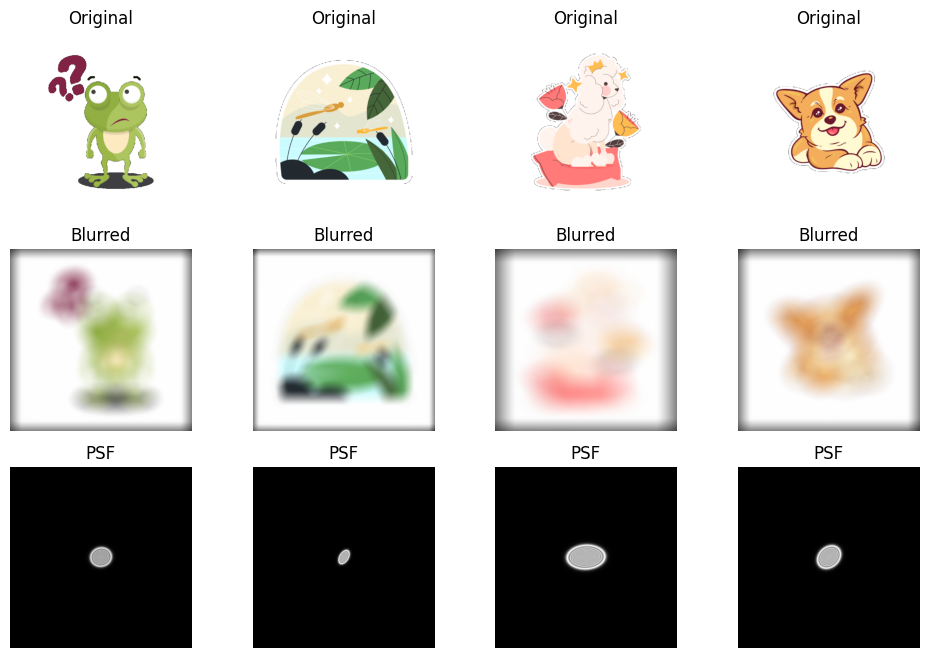

In [37]:
show_blurred(icons[:4], medium_psfs_list)

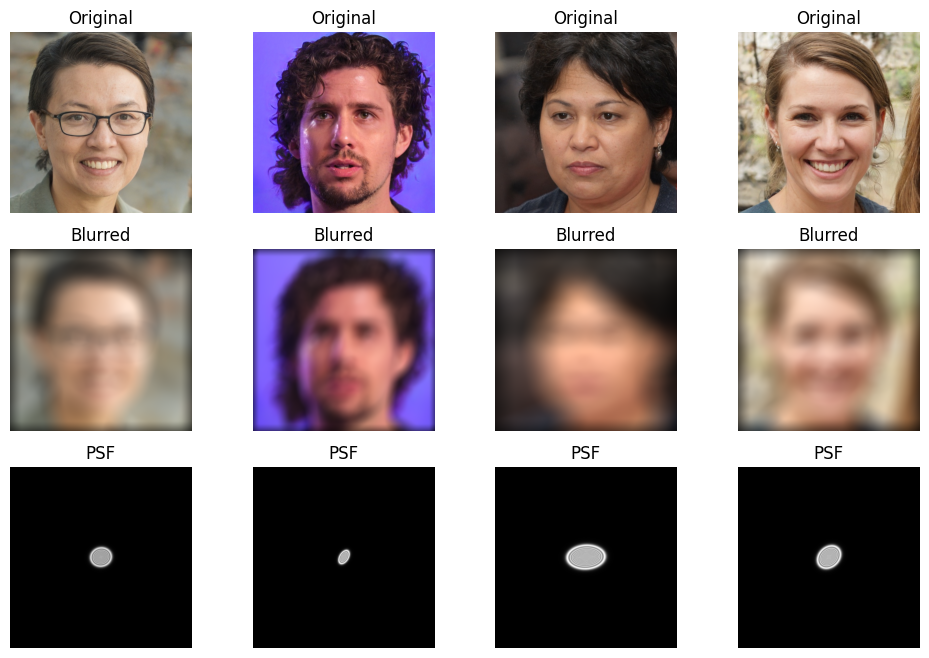

In [38]:
show_blurred(faces[:4], medium_psfs_list)

# 2.3 Deconvolution

In [39]:
def show_restored(
    img_paths: tp.List[PosixPath],
    psfs_list: tp.List[np.array],
    algorithm: tp.Callable,
    **algo_params,
):
    num_images = len(img_paths)
    fig, axs = plt.subplots(4, num_images, figsize=(3*num_images, 8))
    for i in range(num_images):
        image = read_image(str(img_paths[i]))
        psf = np.load(str(psfs_list[0]), allow_pickle=True)[i]['psf']
        convolved = convolve(image, psf)
        restored = algorithm(convolved, psf, **algo_params)

        axs[0, i].imshow(convolved)
        axs[0, i].axis('off')
        axs[0, i].set_title('Blurred')

        axs[1, i].imshow(image)
        axs[1, i].axis('off')
        axs[1, i].set_title('Original')

        axs[2, i].imshow(restored)
        axs[2, i].axis('off')
        axs[2, i].set_title('Restored')

        axs[3, i].imshow(psf)
        axs[3, i].axis('off')
        axs[3, i].set_title('PSF')

### 2.3.1 Wiener

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


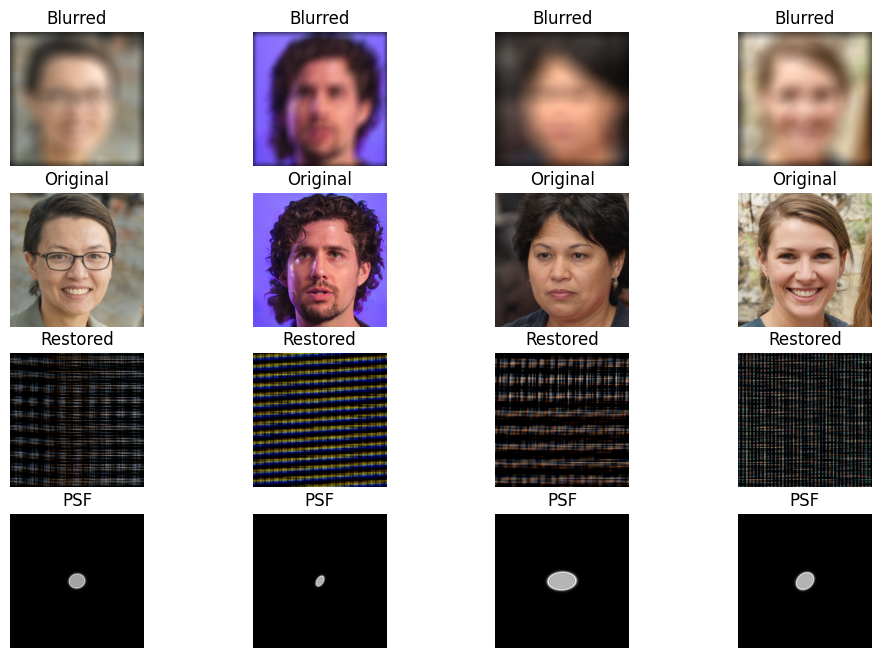

In [64]:
show_restored(faces[:4], medium_psfs_list, wiener_rgb, balance=100)

### 2.3.2 Richardson-Lucy

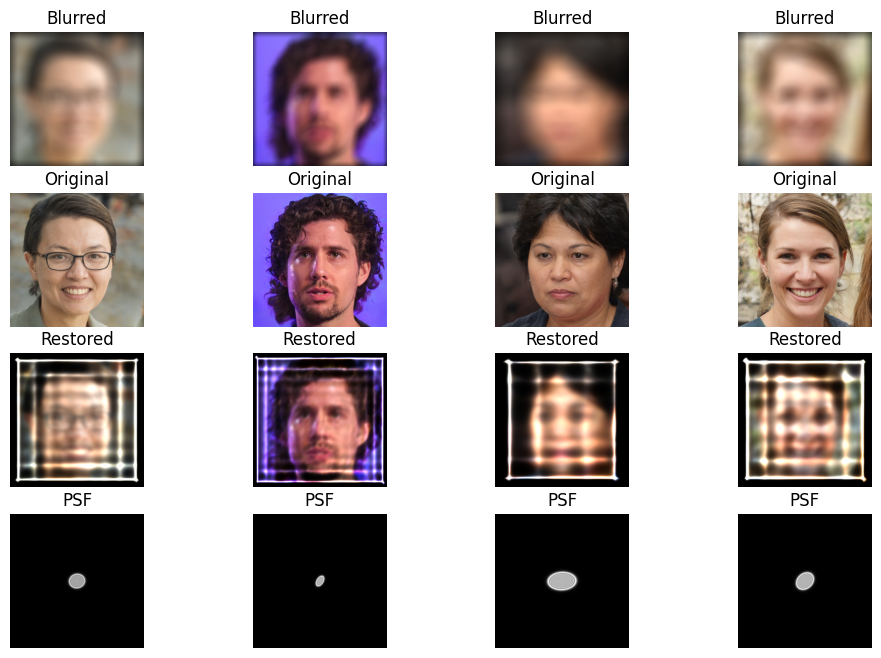

In [41]:
show_restored(faces[:4], medium_psfs_list, richardson_lucy_rgb, num_iter=100)